# Libraries import

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pickle
import random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import xgboost as xgb



## Load the Dataset


In [12]:
# Load the dataset
df = pd.read_csv("synthetic_dataset.csv")

# Check and clean column names
df.columns = df.columns.str.strip()  # Remove spaces
df.columns = df.columns.str.lower()  # Convert to lowercase

## Preprocessing

In [13]:
# Fill missing values with appropriate placeholders
df.fillna({
    "ID_recipient_subsidiary": "UNKNOWN",
    "ID_recipient_institute": "UNKNOWN",
    "UserAgent": "UNKNOWN",
    "ID_sender_subsidiary": "UNKNOWN"
}, inplace=True)

In [14]:
# Hash high-cardinality fields (e.g., IBANs)
high_cardinality_features = [
    "id_recipient_account",
    "id_sender_account"
]
for feature in high_cardinality_features:
    df[feature] = df[feature].apply(lambda x: hash(x) % 10**8)  # Hashing to numeric values

# Encode categorical features
categorical_features = [
    "id_recipient_country",
    "id_recipient_subsidiary",
    "id_recipient_institute",
    "abroad",
    "sepa",
    "channel",
    "instant",
    "useragent",
    "currency"
]

label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

# Apply TF-IDF on 'Causal'
tfidf = TfidfVectorizer(max_features=100)
causal_features = tfidf.fit_transform(df["causal"].astype(str)).toarray()

# Create a DataFrame for TF-IDF features and merge it
causal_df = pd.DataFrame(causal_features, columns=[f"causal_tfidf_{i}" for i in range(causal_features.shape[1])])
df = pd.concat([df.reset_index(drop=True), causal_df], axis=1)
df.drop(columns=["causal"], inplace=True)

# Convert timestamp to datetime features
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y/%m/%d %H:%M:%S", errors="coerce")
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df.drop(columns=["timestamp"], inplace=True)  # Drop original timestamp


In [15]:
# Separate features and target
X = df.drop(columns=["label_fraud_post", "id_recipient_account"])
y = df["label_fraud_post"].astype(int)

In [16]:
# Convert all columns to numeric where possible, dropping non-numeric columns
def ensure_numeric(df):
    non_numeric_columns = []
    for column in df.columns:
        try:
            # Try to convert to numeric
            pd.to_numeric(df[column])
        except ValueError:
            # Keep track of non-numeric columns
            non_numeric_columns.append(column)
    # Drop non-numeric columns
    df = df.drop(columns=non_numeric_columns)
    return df, non_numeric_columns

# Apply the function to clean X
X_clean, dropped_columns = ensure_numeric(X)

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
# Train the model
model = xgb.XGBClassifier().fit(X_train, y_train)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [19]:
# Predict on the test set
y_pred = model.predict(X_test)

In [20]:
# Print metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[58 43]
 [41 58]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.57      0.58       101
           1       0.57      0.59      0.58        99

    accuracy                           0.58       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.58      0.58      0.58       200


Accuracy Score: 0.58


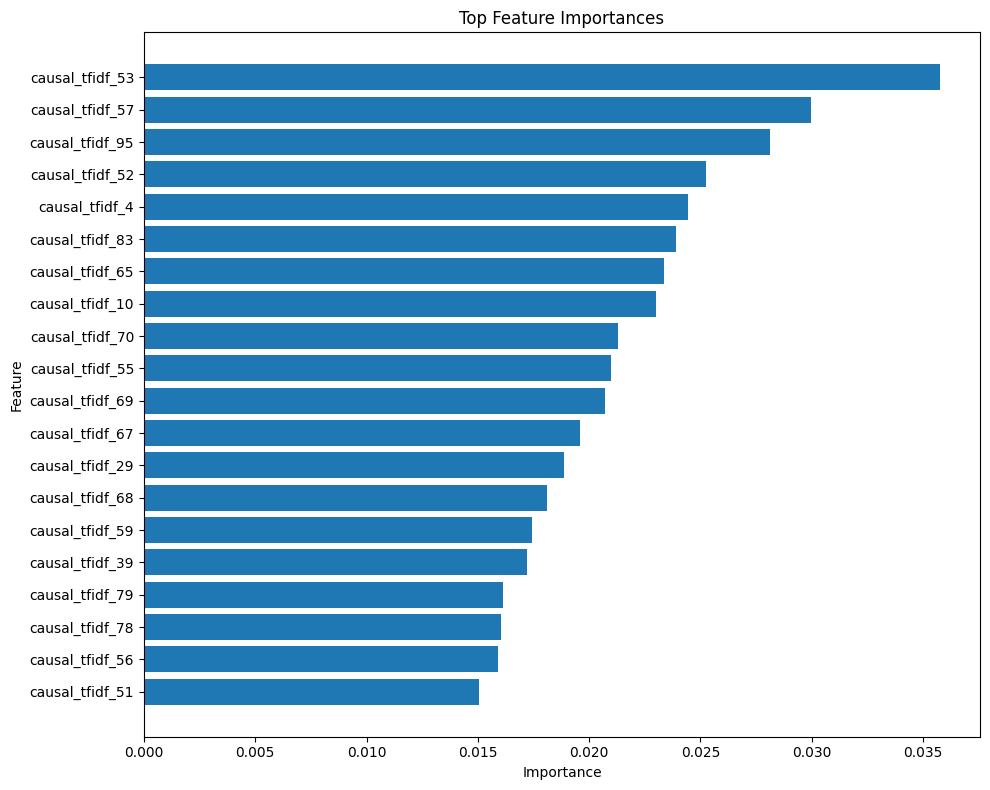

In [21]:
# Get feature importances
feature_importances = model.feature_importances_
feature_names = X_clean.columns

# Number of top features to display
top_n = 20

# Sort features by importance and select top features
sorted_idx = feature_importances.argsort()[-top_n:]
top_feature_names = feature_names[sorted_idx]
top_feature_importances = feature_importances[sorted_idx]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_feature_names, top_feature_importances)
plt.title("Top Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [22]:
# Save the model
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save label encoders and TF-IDF vectorizer
with open("preprocessing_artifacts.pkl", "wb") as f:
    pickle.dump({"label_encoders": label_encoders, "tfidf": tfidf}, f)

In [23]:
# Load the model
with open("random_forest_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Load preprocessing artifacts
with open("preprocessing_artifacts.pkl", "rb") as f:
    artifacts = pickle.load(f)



In [24]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd

In [25]:
# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,             # Training data as a numpy array
    feature_names=X_train.columns,            # Column names
    class_names=["Not Fraud", "Fraud"],       # Class names (adjust based on your dataset)
    mode="classification"                     # Mode can be "classification" or "regression"
)

In [26]:
# Select an instance to explain (for example, the first instance in X_test)
instance = X_test.iloc[0]

# Generate explanation for the selected instance
explanation = explainer.explain_instance(
    data_row=instance.values,             # The instance to explain
    predict_fn=model.predict_proba,       # Prediction function (should return probabilities)
    num_features=10                       # Number of features to show in explanation
)


In [27]:
# Display the explanation in a plot
explanation.show_in_notebook(show_table=True)

# Alternatively, print the explanation as text
print(explanation.as_list())

[('causal_tfidf_40 <= 0.00', -0.18077507196820758), ('causal_tfidf_68 <= 0.00', -0.1754053804987312), ('causal_tfidf_65 <= 0.00', -0.17440291729184268), ('causal_tfidf_52 <= 0.00', -0.16868712534116378), ('causal_tfidf_96 <= 0.00', 0.1644032699173208), ('causal_tfidf_57 <= 0.00', -0.15600856450262116), ('causal_tfidf_59 <= 0.00', -0.1544873010745865), ('causal_tfidf_83 <= 0.00', 0.14859221810801068), ('causal_tfidf_22 <= 0.00', -0.14591162508544722), ('causal_tfidf_80 <= 0.00', 0.14236489540006253)]


In [87]:
import shap

# Create an explainer object
explainer = shap.Explainer(model)
# Calculate SHAP values for the test set
shap_values = explainer(X_test)

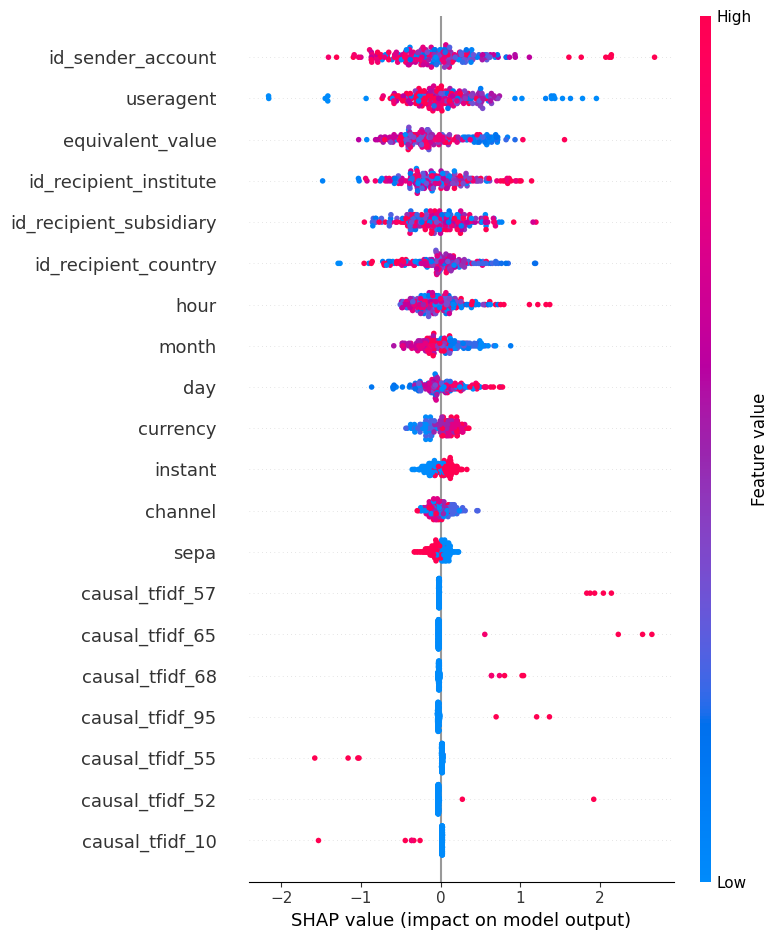

In [88]:
# Summary plot
shap.summary_plot(shap_values, X_test)